# Proyecto IDS
## Integrantes:
- Vicente Alarcón
- Matías Fontecilla

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [48]:
path_file = 'games.csv'

columns = ['AppID', 'Name', 'Release date', 'Estimated owners', 'Price', 'Metacritic score', 'Positive', 'Negative', 'Categories', 'Genres', 'Developers', 'Publishers', 'Median playtime forever', 'Average playtime forever', 'Recommendations', 'User score', 'Supported languages']
df = pd.read_csv(path_file, usecols=columns)
df = df[df['Metacritic score'] > 0]

df['Steam score'] = ((df['Positive'] / (df['Positive'] + df['Negative'])) * 100).round()
df['Steam score'] = df['Steam score'].replace([np.inf, -np.inf], np.nan).fillna(0).astype(int)

# First, split the 'Estimated owners' into two separate columns
df['Lower']= df['Estimated owners'].str.split('-', expand=True)[0]
df['Upper']= df['Estimated owners'].str.split('-', expand=True)[1]
# Convert these columns to numeric
# print(df['Lower'])
df['Lower'] = pd.to_numeric(df['Lower'])
df['Upper'] = pd.to_numeric(df['Upper'])
df['Earnings Range'] = df.apply(lambda row: (row['Lower'] * row['Price'], row['Upper'] * row['Price']), axis=1)
# df['Earnings Range'] = df.apply(lambda row: (str(row['Lower'] * row['Price']) + " - " + str(row['Upper'] * row['Price'])), axis=1)

df = df.loc[df['Positive'] + df['Negative'] > 1000]

# print(df['Estimated owners'].head())
# print(df[['Lower', 'Upper']].head())
# for index, row in df.iterrows():
#     print(f"Lower: {row['Lower']}, Upper: {row['Upper']}, Price: {row['Price']}, Estimated owners: {row['Estimated owners']}")
print(df['Earnings Range'])
df = df.sort_values(by=['Steam score', 'Metacritic score'], ascending=False)
df.to_csv('filtered_games.csv', index=False)

42       (1998999.9999999998, 3997999.9999999995)
66                         (1745000.0, 3490000.0)
96               (49980000.0, 124949999.99999999)
119       (811999.9999999999, 1623999.9999999998)
136                       (9990000.0, 19980000.0)
                           ...                   
78169                                  (0.0, 0.0)
78187                                  (0.0, 0.0)
78218                                  (0.0, 0.0)
78266                      (3999000.0, 7998000.0)
78498                      (3149000.0, 6298000.0)
Name: Earnings Range, Length: 2063, dtype: object


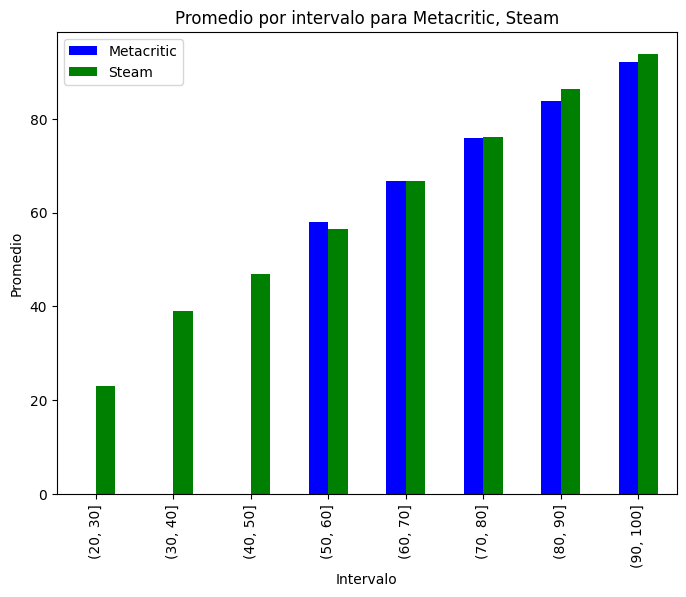

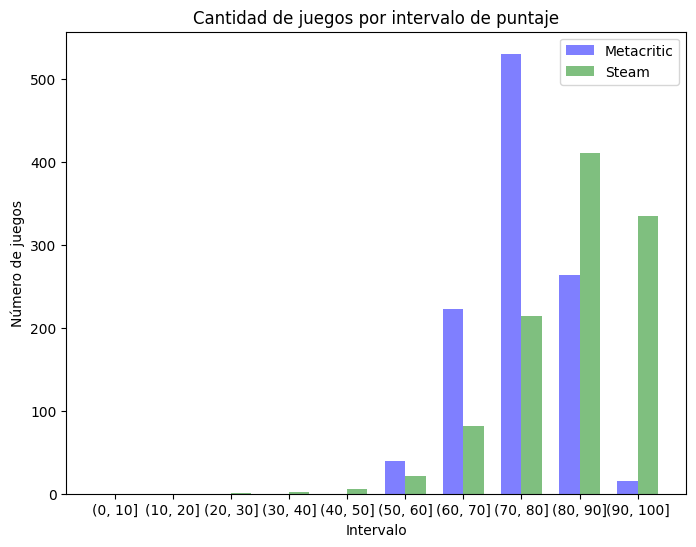

In [26]:
# Leer el archivo CSV
df = pd.read_csv('filtered_games.csv')

# Seleccionar las columnas relevantes
df = df[['AppID', 'Name', 'Metacritic score', 'Steam score', 'Estimated earnings']]

# Crear los intervalos
bins = range(0, 101, 10)

# Dividir los datos en intervalos
df['Intervalo Metacritic'] = pd.cut(df['Metacritic score'], bins)

# Dividir los datos en intervalos
df['Intervalo Steam'] = pd.cut(df['Steam score'], bins)

# Calcular el promedio para cada intervalo
promedio_por_intervalo_metacritic = df.groupby('Intervalo Metacritic', observed=True)['Metacritic score'].mean()

# Calcular el promedio para cada intervalo
promedio_por_intervalo_steam = df.groupby('Intervalo Steam', observed=True)['Steam score'].mean()

# Crear un DataFrame con los promedios por intervalo
df_promedios = pd.DataFrame({
    'Metacritic': promedio_por_intervalo_metacritic,
    'Steam': promedio_por_intervalo_steam,
})

# Calcular el número de filas para cada intervalo
filas_por_intervalo_metacritic = df.groupby('Intervalo Metacritic', observed=True).size()
filas_por_intervalo_steam = df.groupby('Intervalo Steam', observed=True).size()

# Crear un DataFrame con el número de filas por intervalo
df_filas = pd.DataFrame({
    'Metacritic': filas_por_intervalo_metacritic,
    'Steam': filas_por_intervalo_steam,
})

# Graficar los promedios en un solo gráfico de barras
df_promedios.plot.bar(color=['blue', 'green'], figsize=(8, 6))
plt.title('Promedio por intervalo para Metacritic, Steam')
plt.xlabel('Intervalo')
plt.ylabel('Promedio')
plt.show()

conteo_metacritic = df['Intervalo Metacritic'].value_counts().sort_index()
conteo_steam = df['Intervalo Steam'].value_counts().sort_index()

# Graficar los resultados
fig, ax = plt.subplots(figsize=(8, 6))

# Crear un array para las posiciones de las barras
bar_width = 0.35
index = np.arange(len(conteo_metacritic.index))

# Ajustar las posiciones de las barras
ax.bar(index - bar_width/2, conteo_metacritic.values, bar_width, color='blue', alpha=0.5, label='Metacritic')
ax.bar(index + bar_width/2, conteo_steam.values, bar_width, color='green', alpha=0.5, label='Steam')

# Ajustar las etiquetas del eje x para que estén en el centro de las agrupaciones de barras
ax.set_xticks(index)
ax.set_xticklabels(conteo_metacritic.index.astype(str))

ax.set_xlabel('Intervalo')
ax.set_ylabel('Número de juegos')
ax.set_title('Cantidad de juegos por intervalo de puntaje')
ax.legend()

plt.show()

### De estos graficos se puede observar lo siguente: ###
- El los puntajes promedio por intervalo som similares, ya sea, el puntaje de Metacritic o el de Steam 
- Una vez filtrados los datos no quedan punajes de Metacritic menores a 50, por lo que se puede son pocos los juegos que tienen un puntaje menor a 50
- Los puntajes de Metacritic tienden a estar entre 70 y 80, mientras que los de Steam entre 80 y 100 
- Metacritic es mas exigente al momento de dar puntajes altos

De esto se puede ver que los puntajes de Metacritic y Steam son similares, pero Metacritic tiene un menor rango de puntajes. Ademas se puede ver que es mas exigente a comparacion con Steam, ya que, la cantidad de juegos con puntajes entre 80 y 100 son notablemente menos y con aquellos con puntaje entre 60 y 80 son notablemente mas.

C:\Users\ashke\AppData\Local\Temp\ipykernel_2744\544305163.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['Metacritic Score Interval', 'Steam Score Interval'])['Average Earnings'].mean().reset_index()


TypeError: Invalid object type at position 0

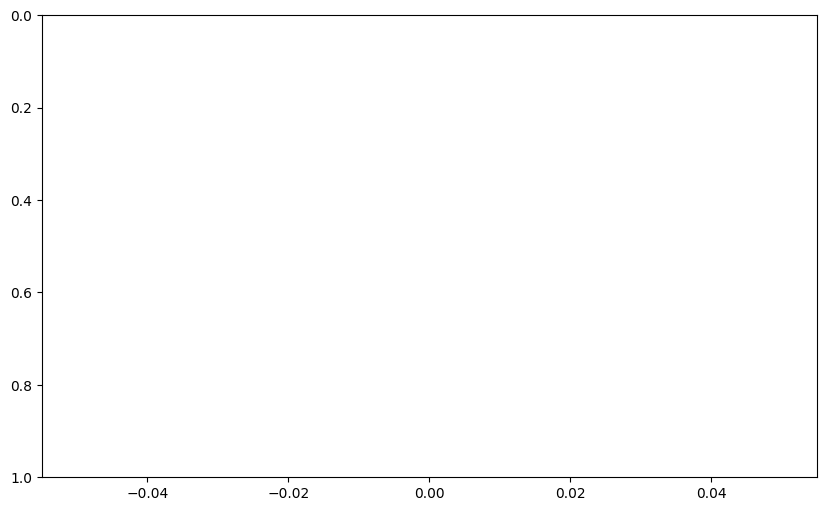

In [52]:
# Leer el archivo CSV
df = pd.read_csv('filtered_games.csv')

# Seleccionar las columnas relevantes
df = df[['AppID', 'Name', 'Metacritic score', 'Steam score', 'Estimated earnings']]

bins = range(0, 101, 10)

df['Intervalo Metacritic'] = pd.cut(df['Metacritic score'], bins)
df['Intervalo Steam'] = pd.cut(df['Steam score'], bins)

promedio_ganancias_por_intervalo_metacritic = df.groupby('Intervalo Metacritic', observed=True)['Estimated earnings'].mean()

promedio_ganancias_por_intervalo_steam = df.groupby('Intervalo Steam', observed=True)['Estimated earnings'].mean()

df_promedios = pd.DataFrame({
    'Metacritic': promedio_ganancias_por_intervalo_metacritic,
    'Steam': promedio_ganancias_por_intervalo_steam,
})

ax = df_promedios.plot.bar(color=['blue', 'green'], figsize=(8, 6))
plt.title('Promedio de ganancias por intervalo de puntaje para Metacritic y Steam')
plt.xlabel('Intervalo')
plt.ylabel('Promedio de ganancias')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()

In [266]:
df = pd.read_csv('filtered_games.csv')

df = df[['Metacritic score', 'Estimated earnings','Positive','Negative'
,'Categories', 'Developers'
]]
df = df.dropna()

df = pd.get_dummies(df, columns=['Categories', 'Developers'])

X = df.drop('Estimated earnings', axis=1)
y = df['Estimated earnings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [267]:
models = [
    # ('Linear Regression', LinearRegression(fit_intercept=False)),
    # ('Lasso', Lasso(alpha=10.0, fit_intercept=True, max_iter=10000)), #{'lasso__alpha': 10.0, 'lasso__fit_intercept': True, 'lasso__max_iter': 1000}
    ('Ridge', Ridge(alpha=10.0, fit_intercept=True,max_iter=None)), #'alpha': 1.0, 'fit_intercept': True, 'max_iter': None}
    ('ElasticNet', ElasticNet(alpha=0.1, fit_intercept=True, l1_ratio=0.9,max_iter=1000)), #{'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'max_iter': 1000}
    ('Decision Tree Regressor', DecisionTreeRegressor(max_depth=10, max_features=None, max_leaf_nodes=None,min_samples_leaf=1,min_samples_split=2)), #{'max_depth': 10, 'max_features': None, 'max_leaf_nodes': -None, 'min_samples_leaf': 1, 'min_samples_split': 2}
    ('Random Forest Regressor', RandomForestRegressor(bootstrap=False, max_depth=None, max_features='log2',min_samples_leaf=1,min_samples_split=10,n_estimators=50, random_state=42)), #{'bootstrap': False, 'max_depth': None, 'max_features': - 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
    ('Gradient Boosting Regressor', GradientBoostingRegressor(learning_rate=0.1, max_depth=3, max_features='sqrt', min_samples_leaf=2, min_samples_split=10, n_estimators=200, subsample=0.5)), #{'learning_rate': 0.1, 'max_depth': 3, ' max_features': -'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.5}
]

for name, model in models:
    # Realizar la validación cruzada
    scores = cross_val_score(model, X_train, y_train, cv=10)
    # Ajustar el modelo a los datos de entrenamiento
    model.fit(X_train, y_train)
    # Hacer predicciones en los datos de prueba
    predictions = model.predict(X_test)
    # Calcular el MSE y el R^2
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print("---------------------------------------------------")
    print(name)
    print(f"Scores de validación cruzada para {name}: {scores}")
    print(f"Promedio de scores para {name}: {scores.mean()}")
    print(f"MSE para {name}: {mse}")
    print(f"R^2 para {name}: {r2}")

---------------------------------------------------
Ridge
Scores de validación cruzada para Ridge: [0.30204542 0.28575238 0.30576759 0.15482945 0.40446251 0.2396775
 0.21614682 0.21336851 0.01696079 0.29911236]
Promedio de scores para Ridge: 0.24381233247296136
MSE para Ridge: 36391907419215.125
R^2 para Ridge: 0.2986685435451678
---------------------------------------------------
ElasticNet
Scores de validación cruzada para ElasticNet: [0.30096008 0.28475411 0.31098116 0.16426348 0.40934218 0.24421134
 0.22016943 0.21203741 0.02235937 0.29541575]
Promedio de scores para ElasticNet: 0.24644943296643557
MSE para ElasticNet: 36248757329318.875
R^2 para ElasticNet: 0.301427279433399
---------------------------------------------------
Decision Tree Regressor
Scores de validación cruzada para Decision Tree Regressor: [ 0.3347851   0.02996677  0.25625359  0.06014712  0.18882263  0.22639271
  0.1731987  -0.12938888  0.10713598  0.03570144]
Promedio de scores para Decision Tree Regressor: 0.12

In [252]:
# Definir los modelos y las cuadrículas de hiperparámetros
lasso_pipeline = make_pipeline(
    StandardScaler(),
    Lasso(max_iter=5000)
)

models_and_params = {
    'Linear Regression': (LinearRegression(), {'fit_intercept': [True, False]}),
    'Ridge': (Ridge(), {'alpha': [0.1, 1.0, 10.0], 'fit_intercept': [True, False], 'max_iter': [None, 100, 1000]}),
    'Lasso': (lasso_pipeline, {'lasso__alpha': [0.1, 1.0, 10.0], 'lasso__fit_intercept': [True, False], 'lasso__max_iter': [1000, 5000, 10000]}),
    'ElasticNet': (ElasticNet(), {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.1, 0.5, 0.9], 'fit_intercept': [True, False], 'max_iter': [1000,5000,10000]}),
    'Decision Tree Regressor': (DecisionTreeRegressor(), {'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': [None, 'sqrt', 'log2'], 'max_leaf_nodes': [None, 10, 20, 30]}),
    'Random Forest Regressor': (RandomForestRegressor(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2'], 'bootstrap': [True, False]}),
    'Gradient Boosting Regressor': (GradientBoostingRegressor(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0], 'max_depth': [3, 5, 10], 'subsample': [0.5, 1.0], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': [None, 'sqrt', 'log2']}),
}

# Para cada modelo, realizar la búsqueda en cuadrícula
for model_name, (model, params) in models_and_params.items():
    print("--------------------------------------------------")
    print(model_name)
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Mejores hiperparámetros para {model_name}: {grid_search.best_params_}")
    print(f"Precisión del mejor modelo: {grid_search.best_score_}")

--------------------------------------------------
Linear Regression
Mejores hiperparámetros para Linear Regression: {'fit_intercept': False}
Precisión del mejor modelo: -582569662889585.8
--------------------------------------------------
Ridge
Mejores hiperparámetros para Ridge: {'alpha': 10.0, 'fit_intercept': True, 'max_iter': None}
Precisión del mejor modelo: 0.21749383011514525
--------------------------------------------------
Lasso


KeyboardInterrupt: 